In [ ]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt

# training deps
import optax
from tqdm import tqdm

import stochastix as stx

jax.config.update('jax_enable_x64', True)
key = rng.PRNGKey(42)

plt.rcParams['font.size'] = 18

# Positive Self-Loop Gene Expression

The model consists of four key reactions:

1. **Transcription**: DNA → mRNA (Hill activator kinetics, $k_{v0} + k_v \frac{K^n}{K^n + P^n}$)
2. **Translation**: mRNA → mRNA + Protein (rate constant $k_p$)  
3. **mRNA degradation**: mRNA → ∅ (rate constant $γ_m$)
4. **Protein degradation**: Protein → ∅ (rate constant $γ_p$)

This simple model captures the essential dynamics of positively self-regulating gene expression and is one of the classic network motifs. The model can be simulated using stochastic simulation algorithms (SSA) or solved deterministically as an ODE system. In the stochasic regime, the model can exibith a bimodal distribution of protein levels, a characteristic that is invisible in the deterministic ODE formulation.

We will optimize this model to maximize the entropy of the final state distribution of the protein.

In [2]:
# Define initial parameters

log_k_v = jnp.log(0.09)
log_k_n = jnp.log(3.5)
log_k_K = jnp.log(50.0)
log_k_v0 = jnp.log(1e-2)

log_k_p = jnp.log(0.025)
log_gamma_m = jnp.log(0.01)
log_gamma_p = jnp.log(0.002)

In [ ]:
from stochastix import Reaction, ReactionNetwork
from stochastix.kinetics import HillActivator, MassAction

network = ReactionNetwork(
    [
        Reaction(
            '0 -> mRNA',
            HillActivator(
                regulator='P',
                v=log_k_v,
                K=log_k_K,
                n=log_k_n,
                v0=log_k_v0,
                transform_v=jnp.exp,
                transform_K=jnp.exp,
                transform_n=jnp.exp,
                transform_v0=jnp.exp,
            ),
            name='Transcription',
        ),
        Reaction(
            'mRNA -> mRNA + P',
            MassAction(log_k_p, transform=jnp.exp),
            name='Translation',
        ),
        Reaction(
            'mRNA -> 0',
            MassAction(log_gamma_m, transform=jnp.exp),
            name='mRNA_deg',
        ),
        Reaction(
            'P -> 0',
            MassAction(log_gamma_p, transform=jnp.exp),
            name='Protein_deg',
        ),
    ]
)

/Users/francesco/Documents/GitHub/jax-ssa/jax_ssa/kinetics/_hill.py:84: UserWarning: `v` is negative. Please ensure the provided `transform_v` maps it to a positive value.
  warnings.warn(
/Users/francesco/Documents/GitHub/jax-ssa/jax_ssa/kinetics/_hill.py:91: UserWarning: `v0` is negative. Please ensure the provided `transform_v0` maps it to a positive value.
  warnings.warn(


In [ ]:
x0 = jnp.array([0.0, 0.0])

max_steps = int(1.5e4)
T = 3600.0

# couple reaction network to stochastic solver in a convenient way
model = stx.StochasticModel(
    network, stx.DifferentiableDirect(), T=T, max_steps=max_steps
)
mf_model = stx.MeanFieldModel(network, T=T)

In [5]:
print(network)

R0 (Transcription):  0 -> mRNA         |  HillActivator
R1 (Translation):    mRNA -> P + mRNA  |  MassAction
R2 (mRNA_deg):       mRNA -> 0         |  MassAction
R3 (Protein_deg):    P -> 0            |  MassAction


## Stochastic Simulations

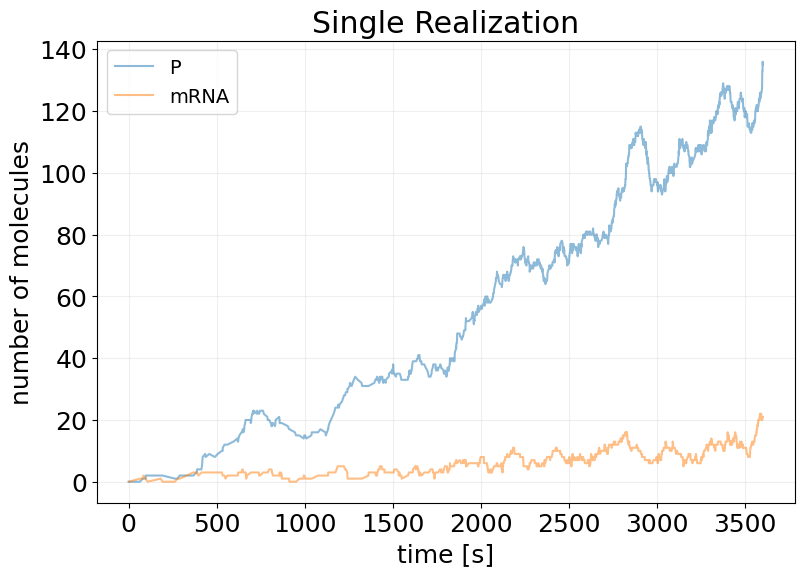

In [ ]:
## Single Realization

key, subkey = rng.split(key)

sim_results = model(subkey, x0)

fig, ax = stx.plot_abundance_dynamic(sim_results)
ax.set_title('Single Realization')
ax.legend(fontsize=14);

In [7]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 1001)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_init_ensemble_fn = eqx.filter_vmap(model, in_axes=(0, None))

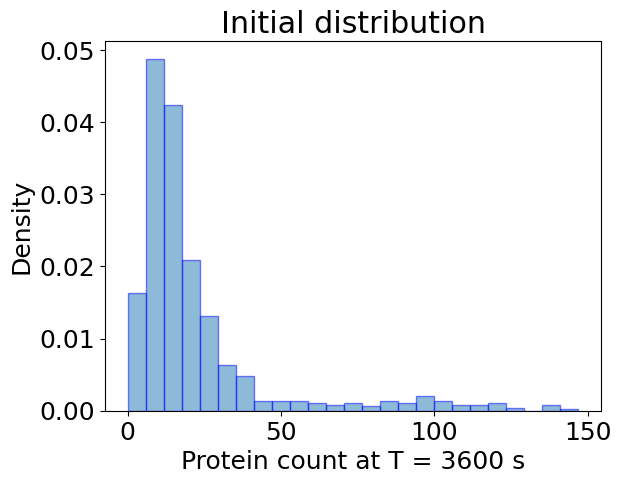

In [8]:
sim_init_ensemble = sim_init_ensemble_fn(subkeys, x0)

plt.hist(
    sim_init_ensemble.x[:, -1, 0],
    bins=25,
    alpha=0.5,
    label='Init.',
    density=True,
    edgecolor='b',
)

plt.xlabel(f'Protein count at T = {T:.0f} s')
plt.ylabel('Density')
plt.title('Initial distribution')
plt.show()

# Maximize Entropy

In [ ]:
def entropy_loss(
    species: str,
    n_simulations: int = 100,
    n_bins: int = 50,
    min_max_vals: tuple[float, float] = None,
    negentropy: bool = False,
):
    """Compute the entropy (bits) of the final state distribution of the model."""

    def _loss(model, x, key):
        subkeys = jnp.array(rng.split(key, n_simulations))

        res = eqx.filter_vmap(model, in_axes=(0, None))(subkeys, x)

        _, probs = stx.utils.differentiable_state_histogram(
            res,
            species=species,
            n_bins=n_bins,
            min_max_vals=min_max_vals,
        )

        log_probs = jnp.log2(jnp.where(probs > 0, probs, 1.0))

        entropy = -jnp.sum(probs * log_probs)

        if negentropy:
            entropy = -entropy

        return entropy

    return _loss

In [10]:
# maximize, so minimize negent
entropy_loss_fn = entropy_loss(
    species='P',
    n_simulations=100,
    n_bins=50,
    min_max_vals=(0, 250),
    negentropy=True,
)

In [11]:
def train_fstate(  # noqa
    key,
    model,
    x0,
    LOSS_FN,
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-3,
):
    # trick to vmap over named arguments
    loss_and_grads = eqx.filter_value_and_grad(LOSS_FN)
    loss_and_grads = eqx.filter_vmap(loss_and_grads, in_axes=(None, None, 0))

    losses = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        loss, grads = loss_and_grads(model, x0, subkeys)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss.mean()

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]

            pbar.set_description(f'Loss: {loss:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

    log = {'loss': losses}

    return model, log

In [12]:
key, train_key = rng.split(key)

reparam_trained_model, log = train_fstate(
    train_key,
    model,
    x0,
    LOSS_FN=entropy_loss_fn,
    EPOCHS=150,
    BATCH_SIZE=1,
    LEARNING_RATE=1e-3,
)

Loss: -5.05: 100%|██████████| 150/150 [03:45<00:00,  1.50s/it]


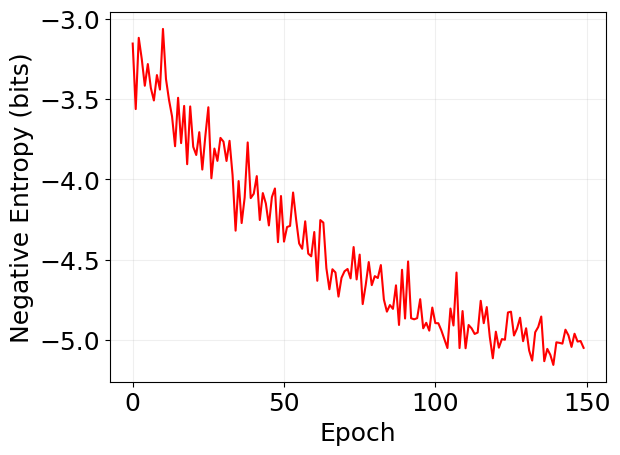

In [13]:
plt.plot(log['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Negative Entropy (bits)')

plt.grid(alpha=0.2)

In [14]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 1001)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_reparam_ensemble_fn = eqx.filter_vmap(reparam_trained_model, in_axes=(0, None))
sim_reparam_ensemble = sim_reparam_ensemble_fn(subkeys, x0)

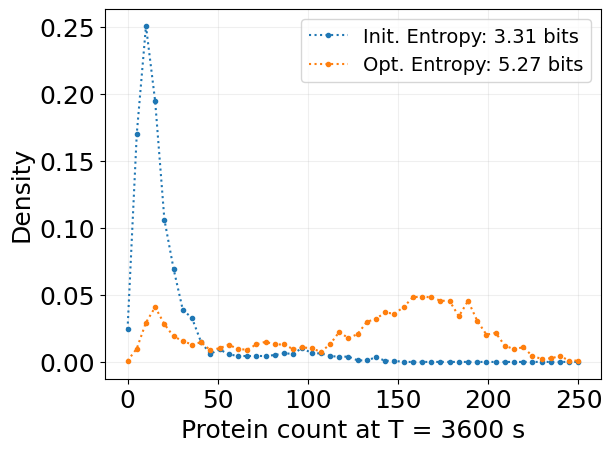

In [ ]:
bins, probs = stx.utils.differentiable_state_histogram(
    sim_init_ensemble, species='P', n_bins=50, min_max_vals=(0, 250)
)

entropy = -jnp.sum(probs * jnp.log2(probs + 1e-10))
plt.plot(bins, probs, '.:', label=f'Init. Entropy: {entropy:.2f} bits')


bins, probs = stx.utils.differentiable_state_histogram(
    sim_reparam_ensemble, species='P', n_bins=50, min_max_vals=(0, 250)
)

entropy = stx.utils.entropy(probs, base=2)
plt.plot(bins, probs, '.:', label=f'Opt. Entropy: {entropy:.2f} bits')

plt.legend(fontsize=14)
plt.grid(alpha=0.2)
plt.xlabel(f'Protein count at T = {T:.0f} s')
plt.ylabel('Density')
plt.show()